In [1]:
from sklearn.metrics import accuracy_score
from support_function.read_data import *
from sklearn.model_selection import train_test_split
from support_function.reporting import reporting
from support_function.evaluate import *
from support_function.labeling_from_score import labeling

In [2]:
df_normalized = read_cleaned_data()

In [3]:
X = np.array(df_normalized[
    [
        "totalAsset",
        "averageTotalAsset",
        "frequencyMountOfTransaction",
        "borrow_per_balance",
        "deposit_per_asset",
        "borrow_per_deposit",
        "totalValueOfLiquidation",
        "numberOfLiquidation",
        "frequencyOfTransaction",
        "frequencyOfDappTransactions",
        "numberOfInteractedDapps",
        "typesOfInteractedDapps",
        "numberOfReputableDapps",
        "age",
    ]
].values)
first_y = df_normalized["1st_label"].values
second_y = df_normalized["2nd_label"].values


X_train, X_test, first_y_train, first_y_test, second_y_train, second_y_test = train_test_split(
    X, first_y, second_y, stratify=first_y, test_size=0.2, random_state=40
)

In [4]:
def new_error_func(y, second_y, y_pred):
    errors = [0] * len(y_pred)
    # Lặp qua từng phần tử trong mảng
    for i in range(len(y_pred)):
        if y[i] == second_y[i]:
            errors[i] = y_pred[i] - y[i]
        else:
            min_value = min(y[i], second_y[i])
            max_value = max(y[i], second_y[i])
            if y_pred[i] <= min_value:
                errors[i] = y_pred[i] - min_value
            if y_pred[i] >= max_value:
                errors[i] = y_pred[i] - max_value
    return errors


def mean_squared_error(X, y, w):
    n = len(y)
    y_pred = labeling(np.dot(X, w))
    error = y_pred - y
    mse = np.sum(error**2) / n
    return mse


# Hàm tính gradient của hàm lỗi (MSE)
def gradient_mean_squared_error(X, y, second_y, w):
    n = len(y)
    y_pred = labeling(np.dot(X, w))
    # error = y_pred - y
    error = new_error_func(y, second_y, y_pred)
    gradient = 2 * np.dot(X.T, error) / n
    return gradient


# Gradient descent để tối ưu hóa hàm lỗi (MSE)
def stochastic_gradient_descent(
    X, y, second_y, learning_rate=0.001, num_iterations=10000, decay_rate=0.95
):
    w = np.random.uniform(0, 1, X.shape[1])
    prev_loss = float("inf")
    for i in range(num_iterations):
        random_index = np.random.randint(0, len(X))
        X_sample = X[random_index : random_index + 1]
        y_sample = y[random_index : random_index + 1]
        second_y_sample = second_y[random_index : random_index + 1]

        grad = gradient_mean_squared_error(X_sample, y_sample, second_y_sample, w)

        w -= learning_rate * grad
        learning_rate *= decay_rate  # Decay learning rate

    return w


In [5]:
max1 = 0
res = None
for i in range(1000):
    learned_weights = stochastic_gradient_descent(
        X_train, first_y_train, second_y_train
    )
    pred = labeling(X_test.dot(learned_weights))
    acc = new_accuracy(first_y_test, second_y_test, pred)
    if acc > max1:
        max1 = acc
        res = learned_weights

In [6]:
predicted_labels = labeling(X_test.dot(res))
print(new_accuracy(first_y_test, second_y_test, predicted_labels))

0.7720899759772876


In [7]:
print(precision(first_y_test, second_y_test, predicted_labels))

0.36934818117250945


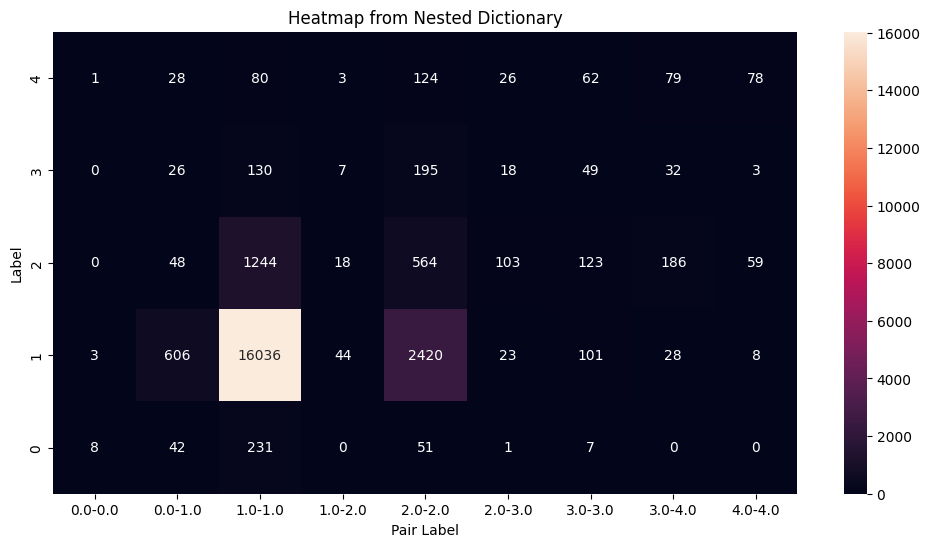

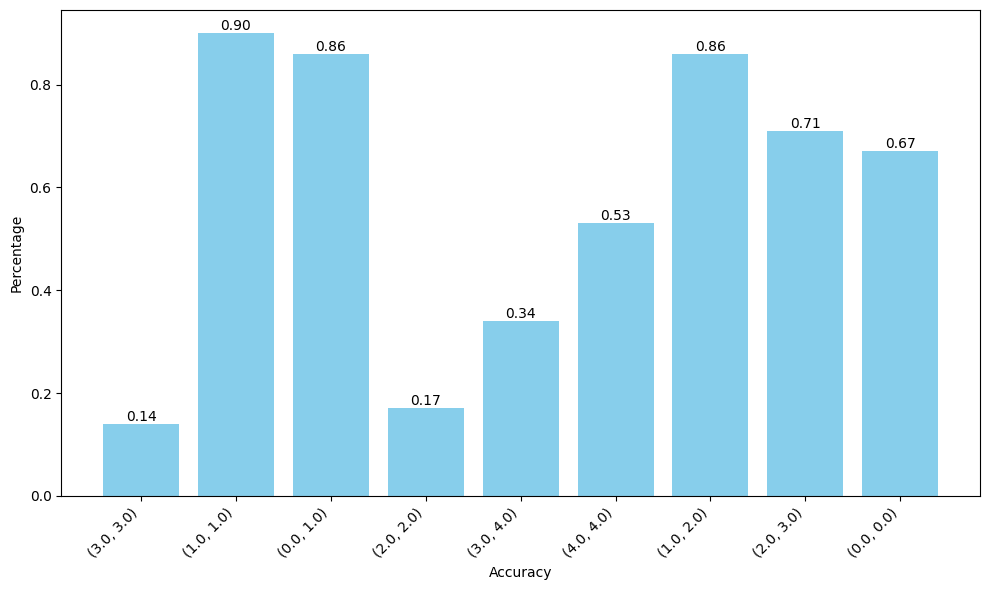

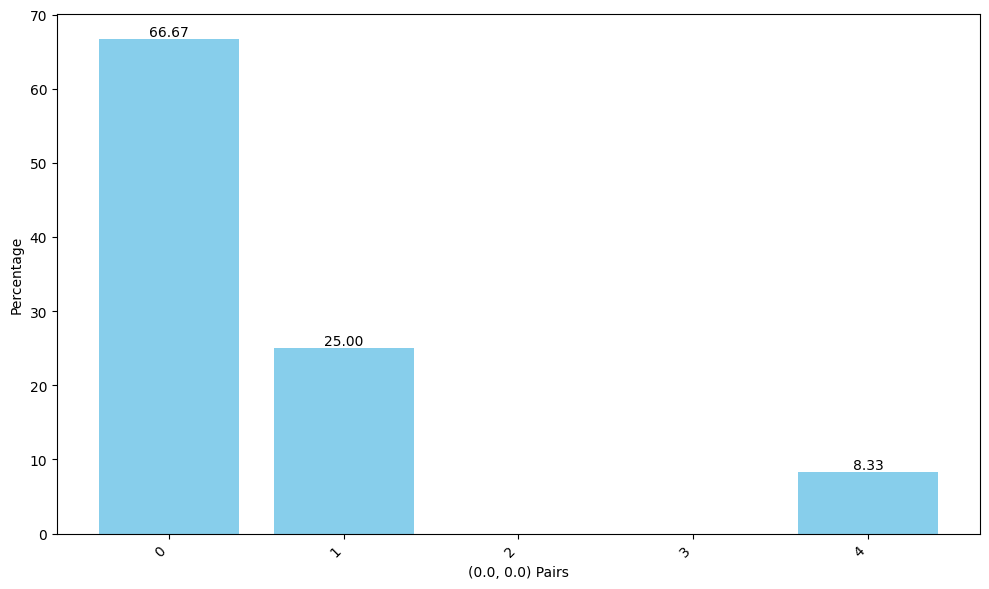

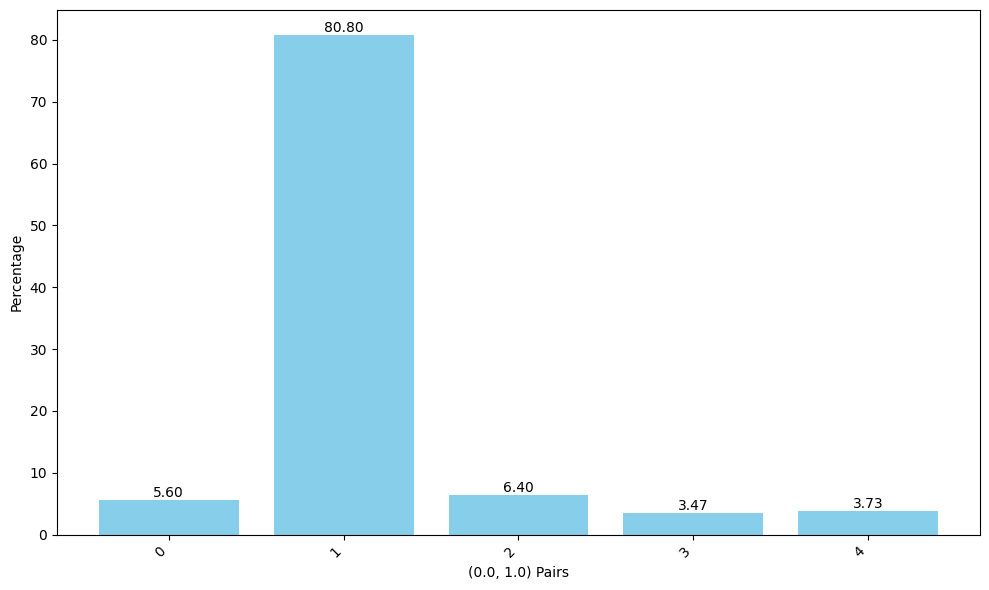

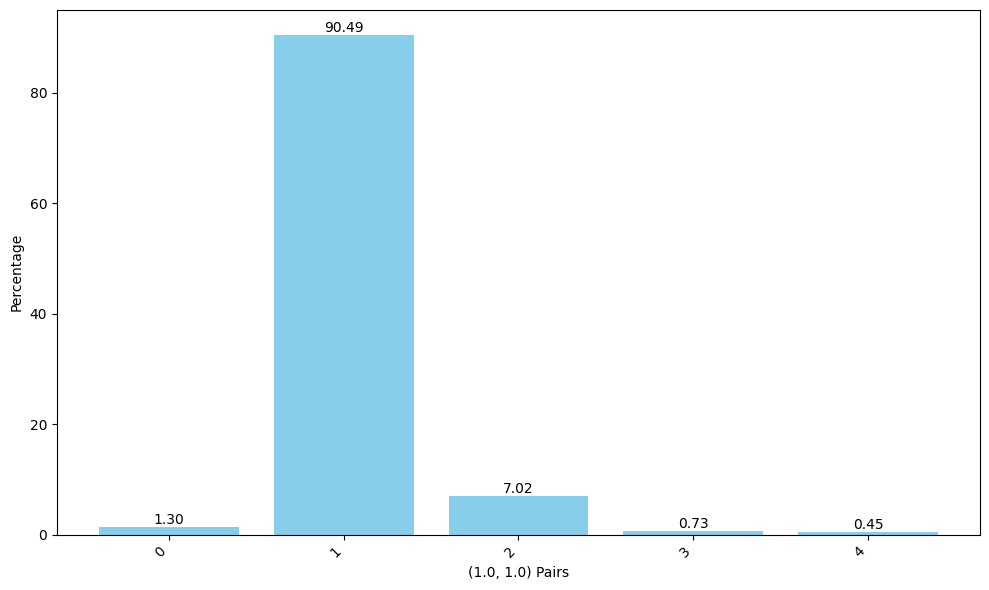

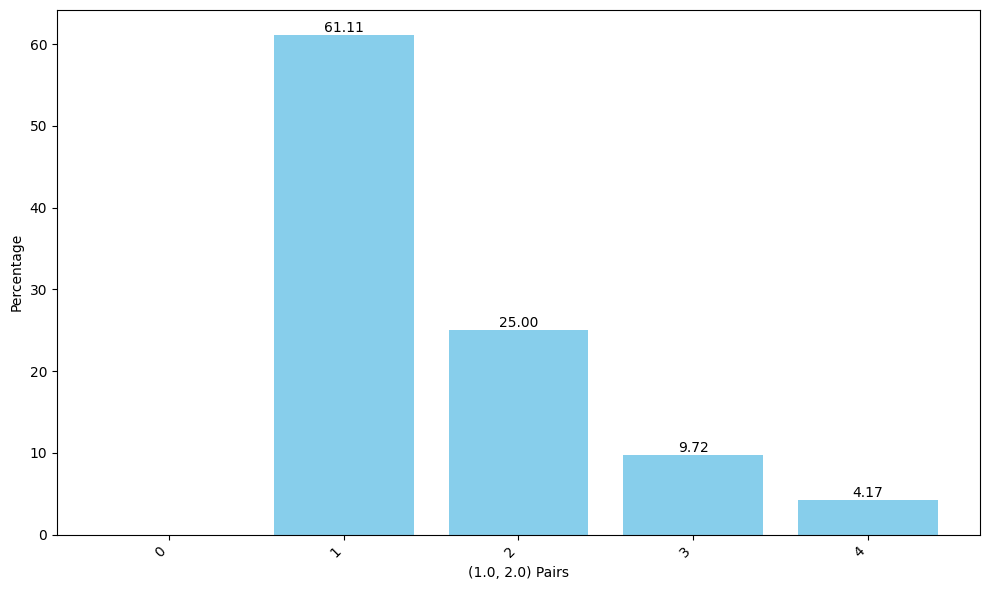

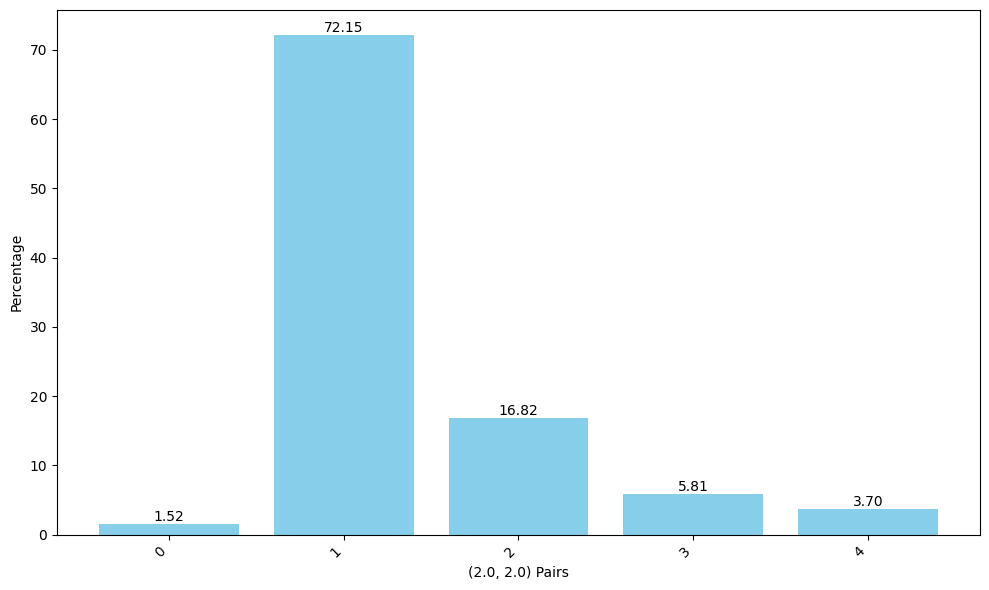

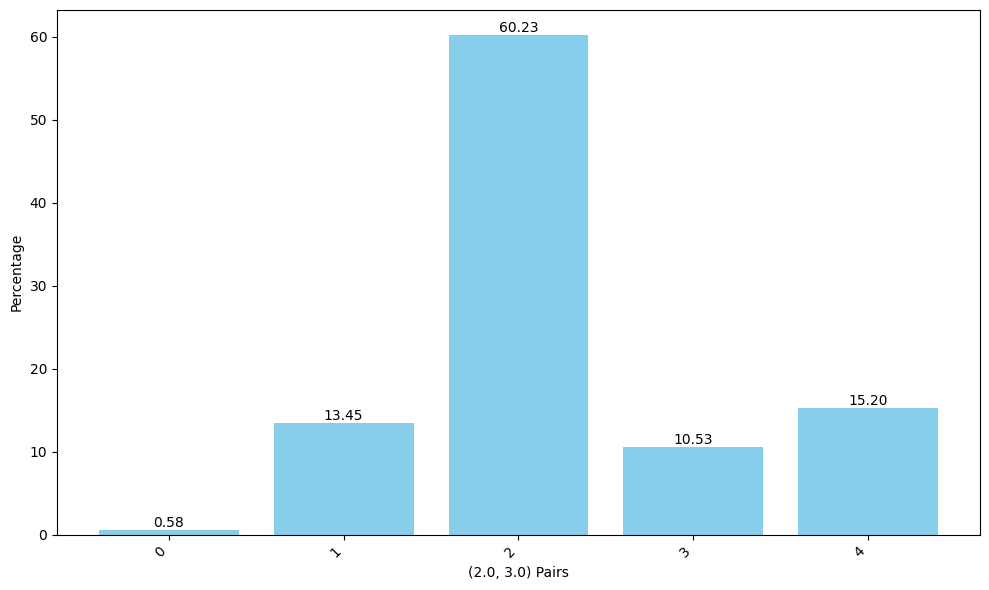

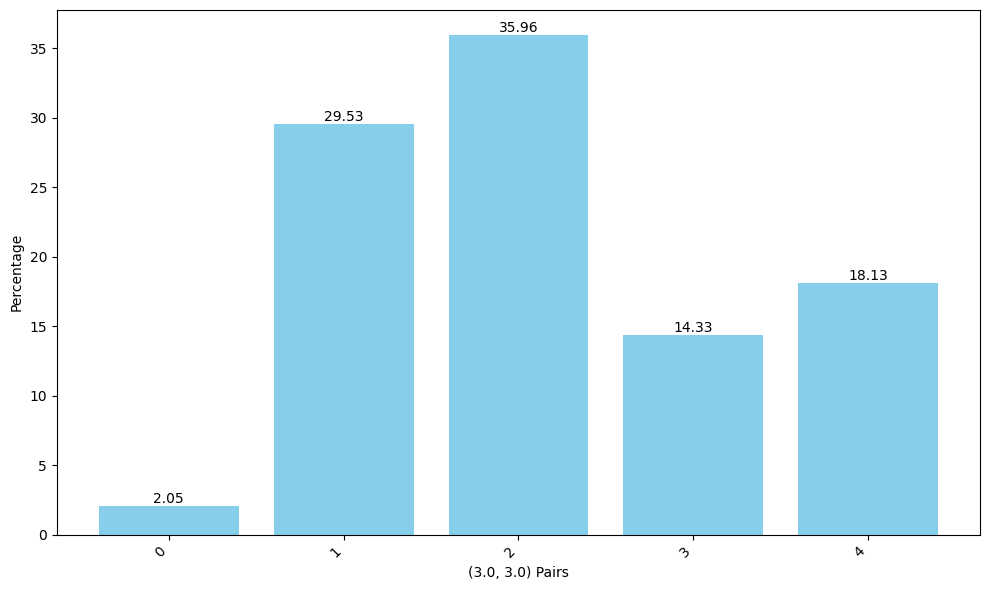

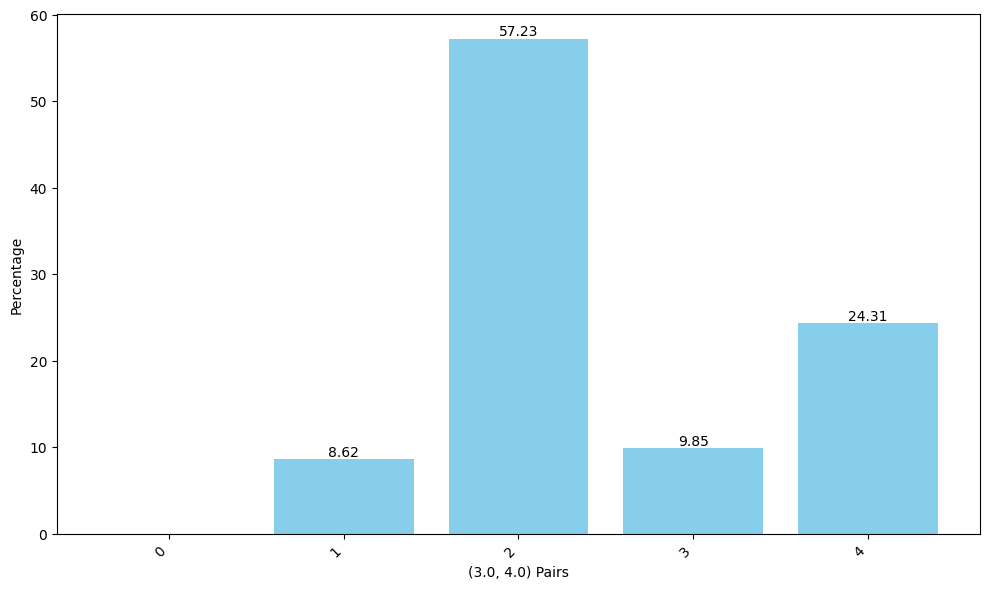

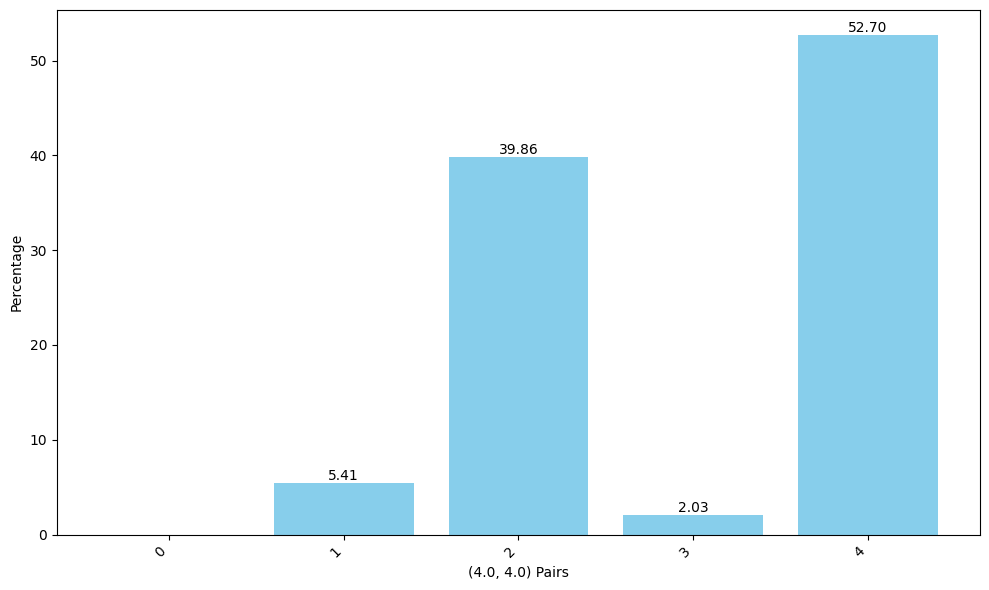

In [8]:
reporting(first_y_test, second_y_test, predicted_labels)